In [ ]:
# === Part 1: Feature Engineering ===

# Import required libraries for data processing, signal analysis, and visualization
import pandas as pd
import numpy as np
import os
from scipy.stats import skew, kurtosis, entropy, iqr
from scipy.fft import fft, fftfreq
from scipy.signal import welch, find_peaks
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from IPython.display import display, HTML

# Suppress matplotlib warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

# Define the dataset folder path
folder_path = "./harth"

# Specify sensor columns to extract features from
sensor_columns = ['back_x', 'thigh_x']

# Set the sampling interval for time-series data (50 Hz = 0.02 sec)
sampling_interval = 0.02


In [ ]:
# Aggregate back_x signal and timestamps from all CSV files for visualization
all_sensor_values = []
all_timestamps = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            if 'timestamp' not in df.columns or 'back_x' not in df.columns:
                continue
            timestamps = pd.to_datetime(df['timestamp'], errors='coerce')
            sensor_data = df['back_x']
            valid = timestamps.notna() & sensor_data.notna()
            timestamps = timestamps[valid].to_numpy()
            sensor_data = sensor_data[valid].to_numpy()
            if len(sensor_data) < 2:
                continue
            all_sensor_values.extend(sensor_data)
            all_timestamps.extend(timestamps)
        except:
            continue

# Store visualization data in numpy arrays
x_viz = np.array(all_sensor_values)
N_viz = len(x_viz)


In [8]:
# Extract time- and frequency-domain features per sensor
rows = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        for sensor_column in sensor_columns:
            if sensor_column not in df.columns:
                continue

            sensor_data = df[sensor_column].dropna().to_numpy()
            if len(sensor_data) < 2:
                continue

            x = sensor_data
            N = len(x)
            sensor_features = {'Sensor': sensor_column}

            # Time-domain features
            sensor_features.update({
                'Mean': np.mean(x),
                'Standard Deviation': np.std(x),
                'Variance': np.var(x),
                'Min': np.min(x),
                'Max': np.max(x),
                'Range': np.ptp(x),
                'Median': np.median(x),
                'IQR': iqr(x),
                'RMS': np.sqrt(np.mean(x**2)),
                'Zero-Crossing Rate': ((x[:-1] * x[1:]) < 0).sum(),
                'Skewness': skew(x),
                'Kurtosis': kurtosis(x),
                'Energy': np.sum(x**2),
                'Autocorrelation (lag 1)': np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else np.nan,
                'Peak Count': len(find_peaks(x)[0]),
                'Peak Amplitude': np.max(x[find_peaks(x)[0]]) if len(find_peaks(x)[0]) > 0 else np.nan,
            })

            # Frequency-domain features
            yf = fft(x)
            xf = fftfreq(N, sampling_interval)[:N // 2]
            amplitudes = 2.0 / N * np.abs(yf[0:N // 2])
            f_psd, psd_values = welch(x, fs=1 / sampling_interval)

            sensor_features.update({
                'Spectral Centroid': np.sum(xf * amplitudes) / np.sum(amplitudes),
                'Spectral Energy': np.sum(amplitudes**2),
                'Spectral Entropy': entropy(amplitudes / np.sum(amplitudes)),
                'Frequency Variance': np.var(amplitudes),
                'Spectral Flatness': np.exp(np.mean(np.log(amplitudes + 1e-10))) / np.mean(amplitudes),
                'Peak Frequency': xf[np.argmax(amplitudes)],
                'Bandwidth': np.max(xf) - np.min(xf),
                'PSD Mean': np.mean(psd_values),
                'PSD Max': np.max(psd_values)
            })

            for i, val in enumerate(amplitudes[:10]):
                sensor_features[f'FFT Coeff {i+1}'] = val

            rows.append(sensor_features)

        break  # Only first valid file


Sensor,Mean,Standard Deviation,Variance,Min,Max,Range,Median,IQR,RMS,Zero-Crossing Rate,Skewness,Kurtosis,Energy,Autocorrelation (lag 1),Peak Count,Peak Amplitude,Spectral Centroid,Spectral Energy,Spectral Entropy,Frequency Variance,Spectral Flatness,Peak Frequency,Bandwidth,PSD Mean,PSD Max,FFT Coeff 1,FFT Coeff 2,FFT Coeff 3,FFT Coeff 4,FFT Coeff 5,FFT Coeff 6,FFT Coeff 7,FFT Coeff 8,FFT Coeff 9,FFT Coeff 10
back_x,-0.8022,0.2383,0.0568,-3.5429,0.9521,4.4950,-0.9372,0.3291,0.8369,48,0.6372,-0.1589,286233.1073,0.9828,154954,0.9521,6.4736,2.6877,11.1515,0.0,0.5586,0.0,24.9998,0.0002,0.0039,1.6044,0.1772,0.1461,0.0396,0.0816,0.0045,0.0204,0.0748,0.0773,0.0555
thigh_x,-0.3703,0.5067,0.2567,-6.8440,3.8985,10.7426,-0.2777,1.0218,0.6276,2027,-0.7578,0.3122,160967.6363,0.9579,154319,3.8985,8.1032,1.0620,11.6438,0.0,0.6601,0.0,24.9998,0.0015,0.0257,0.7406,0.2172,0.3105,0.1211,0.3280,0.0568,0.1348,0.2171,0.1028,0.0499


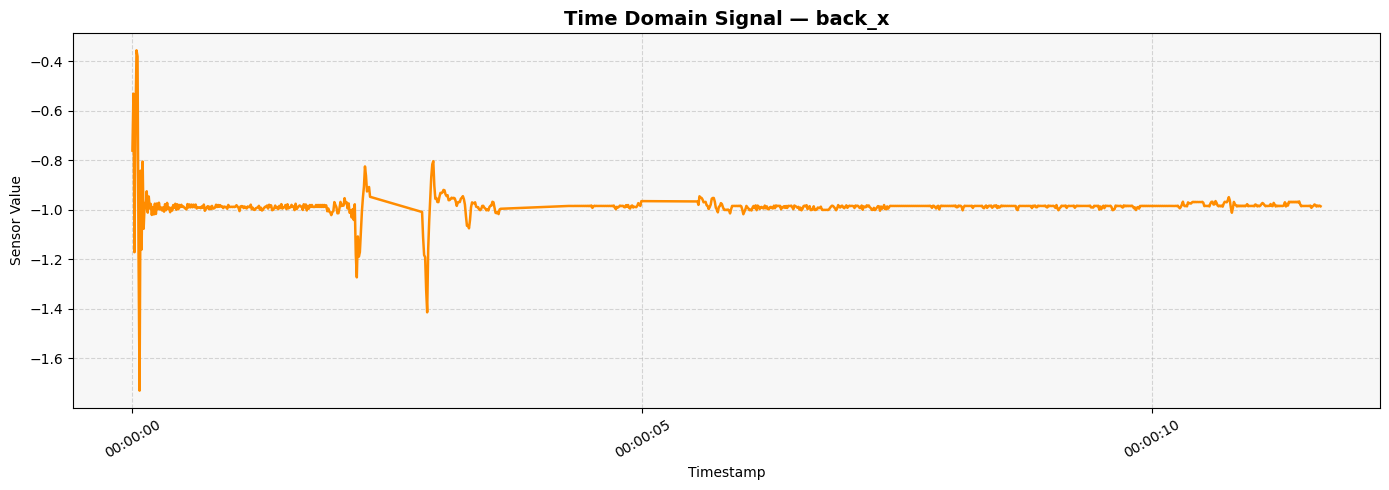

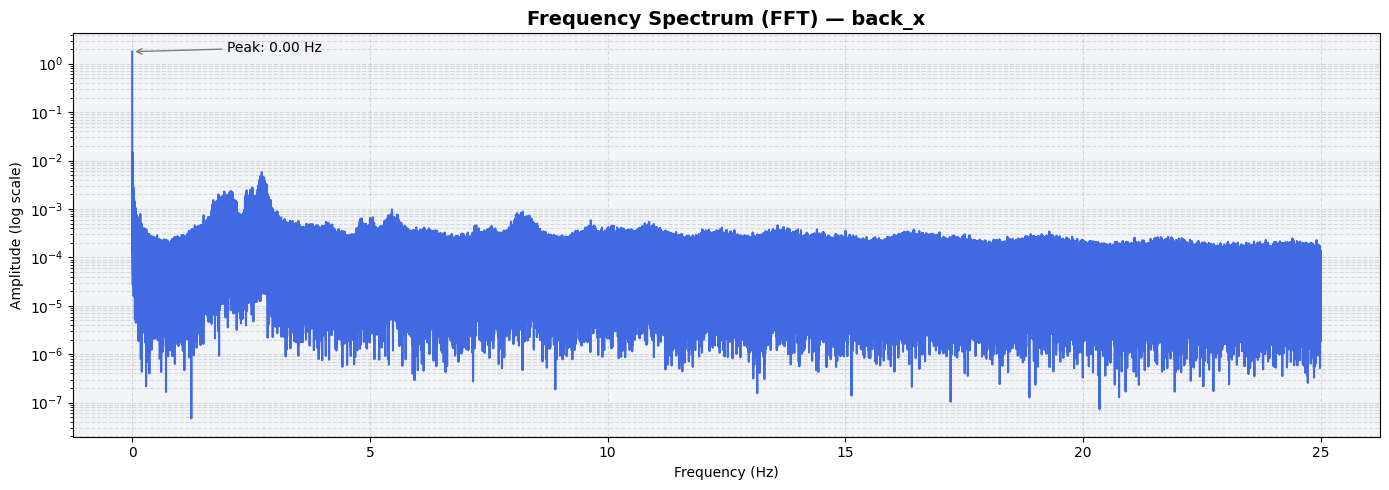

In [ ]:
# Create and display DataFrame with one row per sensor (back_x and thigh_x)
features_df = pd.DataFrame(rows).round(4)

# Convert feature table to scrollable HTML and display it
html_output = features_df.to_html(index=False, max_cols=None, escape=False)
display(HTML(f"<div style='overflow-x:auto'>{html_output}</div>"))

# Plot time-domain signal of back_x
plt.figure(figsize=(14, 5))
plt.plot(all_timestamps[:1000], x_viz[:1000], color='darkorange', linewidth=1.8)
plt.gca().set_facecolor('#f7f7f7')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=30)
plt.title("Time Domain Signal — back_x", fontsize=14, fontweight='bold')
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot frequency-domain FFT spectrum of back_x
yf_viz = fft(x_viz)
xf_viz = fftfreq(N_viz, sampling_interval)[:N_viz // 2]
amplitudes_viz = 2.0 / N_viz * np.abs(yf_viz[0:N_viz // 2])

plt.figure(figsize=(14, 5))
plt.plot(xf_viz, amplitudes_viz, color='royalblue', linewidth=1.5)
plt.gca().set_facecolor('#f2f4f8')
plt.yscale('log')
plt.title("Frequency Spectrum (FFT) — back_x", fontsize=14, fontweight='bold')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (log scale)")
plt.grid(True, which='both', linestyle='--', alpha=0.4)

# Annotate peak frequency in FFT plot
peak_index = np.argmax(amplitudes_viz)
plt.annotate(f"Peak: {xf_viz[peak_index]:.2f} Hz", 
             xy=(xf_viz[peak_index], amplitudes_viz[peak_index]), 
             xytext=(xf_viz[peak_index]+2, amplitudes_viz[peak_index]),
             arrowprops=dict(arrowstyle="->", color='gray'),
             fontsize=10)
plt.tight_layout()
plt.show()


In [10]:
# === Part 1: Feature Selection Using Random Forest ===
from sklearn.ensemble import RandomForestClassifier

# Create dummy labels for feature importance calculation
# In a real setting, this would come from actual activity labels
dummy_labels = [0, 1]  # Back and thigh as two dummy classes
labels_for_rf = [0 if row['Sensor'] == 'back_x' else 1 for row in rows]

# Create feature-only DataFrame (excluding 'Sensor' column)
feature_only_df = features_df.drop(columns=['Sensor'])

# Train Random Forest on the features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(feature_only_df, labels_for_rf)

# Rank features by importance
importances = pd.Series(rf.feature_importances_, index=feature_only_df.columns)
top_features = importances.sort_values(ascending=False).head(10)

# Display top 10 most important features
print("\nTop 10 Most Informative Features Based on Random Forest:")
display(top_features.to_frame(name="Importance").style.format({"Importance": "{:.4f}"}))



Top 10 Most Informative Features Based on Random Forest:


,Importance
Standard Deviation,0.0962
FFT Coeff 1,0.0769
Mean,0.0577
FFT Coeff 2,0.0577
Median,0.0577
Peak Amplitude,0.0577
Zero-Crossing Rate,0.0577
Autocorrelation (lag 1),0.0577
FFT Coeff 4,0.0385
Energy,0.0385
